## Overview

This notebook assumes that `generate_all_reconstructions.py` has been run, and the reconstructions are stored in `./outputs/`.

[Test](#flow-distributions)

In [126]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import genextreme, pearson3
from scipy.optimize import curve_fit
from scipy.stats import genextreme as gev
from scipy.stats import pearson3
from sklearn.preprocessing import StandardScaler
import spei as si

from utils.data_processing import extract_realization_from_hdf5
from utils.drought_plots import plot_ssi

# Directory to pywrdrb project
pywrdrb_directory = '../Pywr-DRB/'
sys.path.append(pywrdrb_directory)

from pywrdrb.pywr_drb_node_data import obs_pub_site_matches, obs_site_matches
from pywrdrb.utils.constants import cms_to_mgd

In [113]:
def aggregate_node_flows(df):
    for node, sites in obs_pub_site_matches.items():
        if sites:
            df.loc[:,node] = df.loc[:, sites].sum(axis=1)    
    df['NYC Total']= df.loc[:,['cannonsville', 'pepacton', 'neversink']].sum(axis=1)
    return df

In [127]:
# Load different reconstruction variations
Q_reconst = {}
for fdc_source in ['nhmv10', 'nwmv21']:
    Q_reconst[fdc_source]= {}
    # Non NYC-scaled
    df = pd.read_csv(f'./outputs/historic_reconstruction_daily_{fdc_source}_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
    Q_reconst[fdc_source]['unscaled'] = aggregate_node_flows(df)
    
    # NYC-scaled
    df = pd.read_csv(f'./outputs/historic_reconstruction_daily_{fdc_source}_NYCscaled_mgd.csv', sep = ',', index_col = 0, parse_dates = True)
    Q_reconst[fdc_source]['scaled'] = aggregate_node_flows(df)


    # Load ensemble flows
    n_realizations= 30
    ensemble_filename= f'./outputs/ensembles/historic_reconstruction_daily_{fdc_source}_ensemble_mgd.hdf5'
    Q_reconst[fdc_source]['ensemble'] = {}

    for i in range(n_realizations):
        df = extract_realization_from_hdf5(ensemble_filename, realization=i+1)
        
        Q_reconst[fdc_source]['ensemble'][f'realization_{i}']= aggregate_node_flows(df)

# Load historic observations
Q_obs = pd.read_csv('./outputs/streamflow_daily_usgs_1950_2022_cms.csv', sep=',', index_col=0, parse_dates=True)*cms_to_mgd


## Visual overlay

Quick visual of all reconstructions overlaid on one another for nodes of interest.

In [128]:
reconst_colordict = {'nwmv21':{'scaled': 'brown',
                               'unscaled':'tomato',
                               'ensemble':'pink'},
                     'nhmv10':{'scaled':'navy',
                               'unscaled': 'steelblue',
                               'ensemble': 'powderblue'}}

reconst_lsdict = {'scaled': 'dashed',
                  'unscaled':'solid'}

In [130]:
obs_site_matches

{'cannonsville': ['01423000'],
 'pepacton': ['01415000', '01414500', '01414000', '01413500'],
 'neversink': ['01435000'],
 'wallenpaupack': [],
 'prompton': [],
 'shoholaMarsh': [],
 'mongaupeCombined': [],
 'beltzvilleCombined': ['01449360'],
 'fewalter': ['01447720', '01447500'],
 'merrillCreek': [],
 'hopatcong': [],
 'nockamixon': [],
 'assunpink': [],
 'ontelaunee': [],
 'stillCreek': [],
 'blueMarsh': [],
 'greenLane': ['01472199', '01472198'],
 '01425000': ['01425000'],
 '01417000': ['01417000'],
 'delLordville': ['01427207'],
 '01436000': ['01436000'],
 '01433500': ['01433500'],
 'delMontague': ['01438500'],
 '01449800': ['01449800'],
 '01447800': ['01447800'],
 'delDRCanal': ['01463500'],
 'delTrenton': ['01463500'],
 '01463620': ['01463620'],
 'outletAssunpink': ['01464000'],
 '01470960': ['01470960'],
 'outletSchuylkill': ['01474500']}

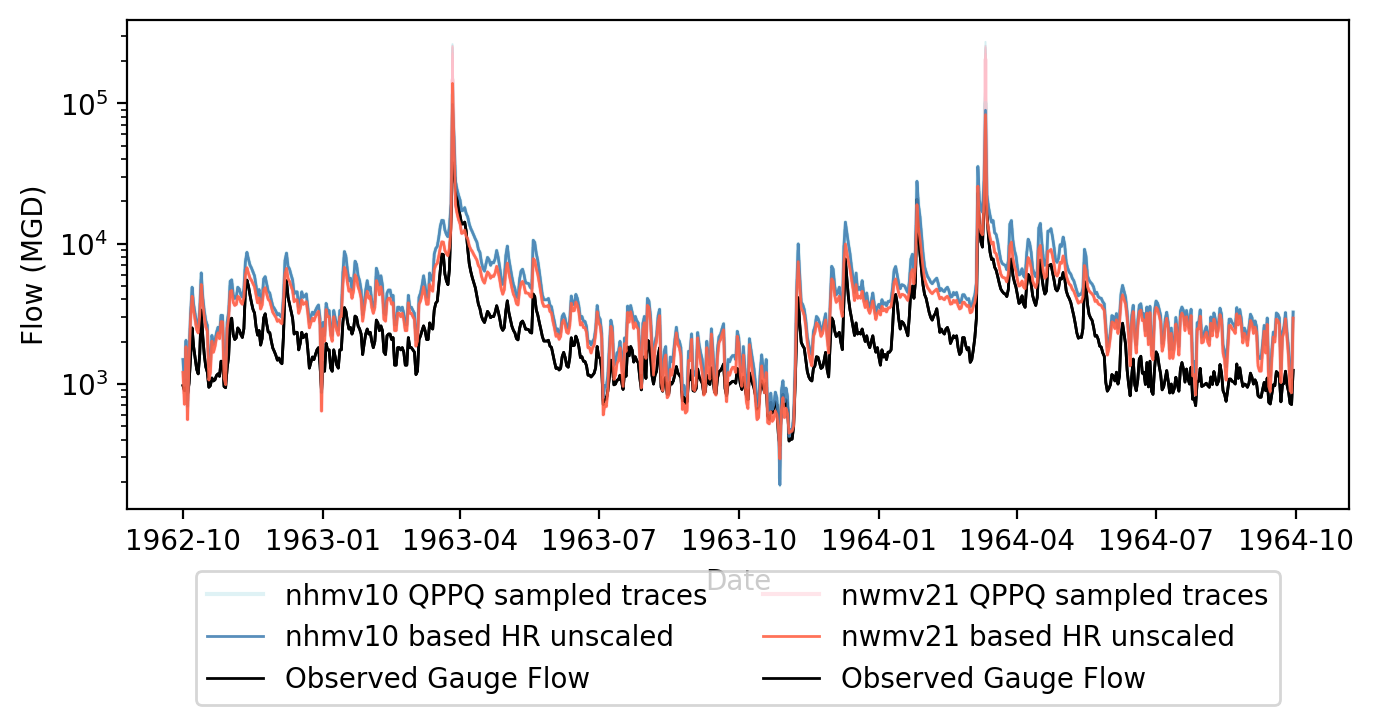

In [133]:

t_start= '1962-10-01'
t_end= '1964-09-29'
plot_node= 'delMontague' #'01436000' #'delTrenton'
plot_type= 'timeseries' #'timeseries' # Options: fdc, timeseries

fig, ax= plt.subplots(figsize=(7,4), dpi=200)

fdc_quantiles= np.linspace(0.00001,0.99999,200)

consider_datasets=['unscaled', 'scaled'] if plot_node in ['cannonsville', 'pepacton', 'NYC Total'] else ['unscaled']


for fdc_source in ['nhmv10', 'nwmv21']:
    if plot_node not in ['cannonsville', 'pepacton','NYC Total']:
        
        for i in range(n_realizations):            
            Q_hr= Q_reconst[fdc_source]['ensemble'][f'realization_{i}']
            c = reconst_colordict[fdc_source]['ensemble']
            
            if plot_type == 'timeseries':
                if i == 0:
                    ax.plot(Q_hr.loc[t_start:t_end, plot_node], color=c, alpha=0.4, label= f'{fdc_source} QPPQ sampled traces')
                else:
                    ax.plot(Q_hr.loc[t_start:t_end, plot_node], color=c, alpha=0.5, lw=0.7, zorder=1)
                    
            elif plot_type == 'fdc':
                
                fdc_vals= np.quantile(Q_hr[plot_node].values.flatten(), fdc_quantiles)
                ax.plot(fdc_quantiles, fdc_vals, color=c, alpha=0.25)

    # Run different single-trace versions
    for s in consider_datasets:
        Q_hr= Q_reconst[fdc_source][s]
        c = reconst_colordict[fdc_source][s]
        
        if plot_type == 'timeseries':
            ax.plot(Q_hr.loc[t_start:t_end, plot_node], color=c, label= f'{fdc_source} based HR {s}', 
                    alpha=0.9, ls=reconst_lsdict[s], lw=1, zorder=3)
        elif plot_type == 'fdc':
            fdc_vals= np.quantile(Q_hr[plot_node].values.flatten(), fdc_quantiles)
            ax.plot(fdc_quantiles, fdc_vals, color=c, label= f'{fdc_source} based HR {s}')
    
    # If a obs gauge is included, add that
    if obs_site_matches[plot_node]:
        ax.plot(Q_obs.loc[t_start:t_end, f'USGS-{obs_site_matches[plot_node][0]}'],
                color = 'black', lw=1, label = 'Observed Gauge Flow')
        
        
ax.set_xlabel('Date')
ax.set_ylabel('Flow (MGD)')
ax.set_yscale('log')
h, l = ax.get_legend_handles_labels()
legend= ax.legend(h,l,loc='lower center', bbox_to_anchor=(0.5, -0.43), ncol=2)
plt.tight_layout()

plt.show()

